# Анализ данных NGS. Домашнее задание № 7

Выполнил: Олег Вавулов

In [84]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm

#### 0. Контроль качества и фильтрация ридов

Прогнали риды через fastQC. Для прямых ридов все ок, по обратным есть падение качества в конце прочтений

<img src="./bad_quality.png" width=500 height=500/>

Прогоним риды через trimmomatic, чтобы отфильтровать их по качеству

trimmomatic PE -phred33 -trimlog trimlog.txt -summary trimsummary.txt SRR453566_1.fastq.gz SRR453566_2.fastq.gz out_1P.fq out_1U.fq out_2P.fq out_2U.fq LEADING:20 TRAILING:20 SLIDINGWINDOW:10:20 MINLEN:20

TrimmomaticPE: Started with arguments:
 -phred33 -trimlog trimlog.txt -summary trimsummary.txt SRR453566_1.fastq.gz SRR453566_2.fastq.gz out_1P.fq out_1U.fq out_2P.fq out_2U.fq LEADING:20 TRAILING:20 SLIDINGWINDOW:10:20 MINLEN:20
Input Read Pairs: 5725730 Both Surviving: 5652116 (98,71%) Forward Only Surviving: 64968 (1,13%) Reverse Only Surviving: 7314 (0,13%) Dropped: 1332 (0,02%)
TrimmomaticPE: Completed successfully

При этом отфильтрованные риды будем использовать только при сборке. При референсном анализе будем использовать сырые риды, чтобы ненароком не внести смещение

#### 1. Индексируем референс

hisat2-build ref.fa hw7reference

#### 2. Делаем выравнивание

hisat2 -p 4 -x ./hw7reference 

-1 SRR453566_1.fastq.gz -2 SRR453566_2.fastq.gz | 

samtools sort > ./hw7alignment.bam

Output:

5725730 reads; of these:

  5725730 (100.00%) were paired; of these:
  
    1190830 (20.80%) aligned concordantly 0 times
    4291344 (74.95%) aligned concordantly exactly 1 time
    243556 (4.25%) aligned concordantly >1 times
    ----
    1190830 pairs aligned concordantly 0 times; of these:
      136484 (11.46%) aligned discordantly 1 time
    ----
    1054346 pairs aligned 0 times concordantly or discordantly; of these:
      2108692 mates make up the pairs; of these:
        1419212 (67.30%) aligned 0 times
        637771 (30.24%) aligned exactly 1 time
        51709 (2.45%) aligned >1 times
87.61% overall alignment rate

#### 3. Подсчитываем риды
Будем считать попадания ридов с помощью featureCounts. Парные риды рассматриваем как один фрагмент для дальнейшего корректного расчета метрик покрытия

featureCounts -a genes.gtf.gz -t 'gene' -R SAM -p -T 4 -o total_counts.txt ./hw7alignment.bam

Для начала подсчитаем покрытие каждого гена по метрике TPM

In [25]:
count_df = pd.read_csv("total_counts.txt", sep="\t", skiprows=1)
new_col_names = list(count_df.columns)
new_col_names[-1] = "Counts"
count_df.columns = new_col_names

# нормируем на длину гена в килобазах
count_df["RPK"] = count_df.Counts / (count_df.Length * 0.001)
# расчитываем TPM
scaling_factor = count_df.RPK.sum() / 1e6
count_df["TPM"] = count_df["RPK"] / scaling_factor

print(f"Total genes number: {len(count_df.Geneid.unique())}")
count_df.head()

Total genes number: 7126


,Geneid,Chr,Start,End,Strand,Length,Counts,RPK,TPM
0,YDL248W,IV,1802,2953,+,1152,324,281.250000,55.672541
1,YDL247W-A,IV,3762,3836,+,75,9,120.000000,23.753618
2,YDL247W,IV,5985,7814,+,1830,10,5.464481,1.081677
3,YDL246C,IV,8683,9756,-,1074,7,6.517691,1.290156
4,YDL245C,IV,11657,13360,-,1704,21,12.323944,2.439485


(7126, 7126)

Построим распределение покрытия

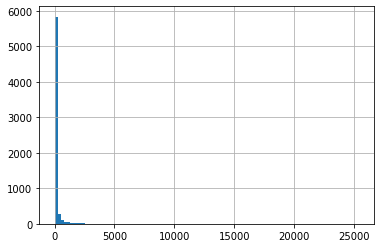

In [29]:
tpm = count_df.TPM
tpm[tpm > 0].hist(bins=100);

In [48]:
tpm_threshold = 0
print(f"Fraction of genes with TPM above {tpm_threshold}: \
{100*len(tpm[tpm > tpm_threshold])/len(tpm):.2f}%")

Fraction of genes with TPM above 0: 90.46%


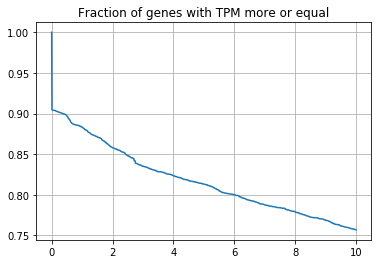

In [49]:
x = np.linspace(0, 10, 1000)
y = [len(tpm[tpm >= i])/len(tpm) for i in x]
plt.title("Fraction of genes with TPM more or equal")
plt.grid()
plt.plot(x, y);

Будем считать, что не экспрессируются гены с TPM = 0. В таком случае экспрессирующихся генов равен:

In [95]:
TPM_LOWER_BOUND = 0

Теперь отфильтруем слабопокрытые гены

In [96]:
COVERAGE_LOWER_BOUND = 0.95

bedtools genomecov -ibam ./hw7alignment.bam -d > ./detailed_coverage_hist.tsv

In [76]:
cov_df = pd.read_csv("detailed_coverage_hist.tsv", sep="\t", header=None)
cov_df.columns = ["chrom", "pos", "cov"]
cov_df.sample(n=3, random_state=19)

,chrom,pos,cov
3557395,V,139774,1038
10503931,XV,386184,61
10054074,XIV,720660,105


In [87]:
i = 0
gene_cocount_dfst = []
for i in tqdm(range(len(count_df))):
    gene, chrom, start, end = count_df.iloc[i, :4]
    gene_cov = cov_df[(cov_df.chrom == chrom) & (cov_df.pos >= start) & (cov_df.pos <= end)]
    gene_cov_list.append(sum(gene_cov["cov"] > 0)/(end - start + 1))

100%|██████████| 7126/7126 [1:11:20<00:00,  1.66it/s]


In [90]:
count_df["Coverage"] = gene_cov_list
count_df.head()

,Geneid,Chr,Start,End,Strand,Length,Counts,RPK,TPM,Coverage
0,YDL248W,IV,1802,2953,+,1152,324,281.250000,55.672541,1.0
1,YDL247W-A,IV,3762,3836,+,75,9,120.000000,23.753618,1.0
2,YDL247W,IV,5985,7814,+,1830,10,5.464481,1.081677,1.0
3,YDL246C,IV,8683,9756,-,1074,7,6.517691,1.290156,1.0
4,YDL245C,IV,11657,13360,-,1704,21,12.323944,2.439485,1.0


In [100]:
selected_genes = count_df[
    (count_df.TPM > TPM_LOWER_BOUND) & \
    (count_df.Coverage > COVERAGE_LOWER_BOUND)
]
len(selected_genes), len(count_df), len(selected_genes)/len(count_df)

(6435, 7126, 0.9030311535223127)

In [101]:
print(f"Fraction of expressed genes: {100*len(selected_genes)/len(count_df):.2f}%")

Fraction of expressed genes: 90.30%


#### Сборка
Для сборки воспользуемся rnaSPAdes на отфильтрованных ридах

../../bin/SPAdes-3.14.1-Darwin/bin/rnaspades.py -1 out_1P.fq -2 out_2P.fq -t 4 -o transriptome_assembly

Не удалось установить rnaQUAST. Выравнял полученные контиги на референс

seqtk seq -F '#' ./transriptome_assembly/transcripts.fasta > ./transriptome_assembly/transcripts.fq

hisat2 -p 4 -x ./hw7reference -U ./transriptome_assembly/transcripts.fq | samtools sort > ./assembly_eval/assembly_alignment.bam

6100 reads; of these:

  6100 (100.00%) were unpaired; of these:
    981 (16.08%) aligned 0 times
    5078 (83.25%) aligned exactly 1 time
    41 (0.67%) aligned >1 times
    
83.92% overall alignment rate

Считаем покрытие

bedtools genomecov -ibam ./assembly_eval/assembly_alignment.bam -d > ./assembly_coverage_hist.tsv

In [4]:
assembled_df = pd.read_csv("assembly_coverage_hist.tsv", sep="\t", header=None)
assembled_df.columns = ["chrom", "pos", "cov"]
assembled_df.sample(n=3, random_state=19)

,chrom,pos,cov
3557395,V,139774,1
10503931,XV,386184,0
10054074,XIV,720660,2


In [6]:
i = 0
gene_cov_list = []
for i in tqdm(range(len(count_df))):
    gene, chrom, start, end = count_df.iloc[i, :4]
    gene_cov = assembled_df[
        (assembled_df.chrom == chrom) & \
        (assembled_df.pos >= start) & \
        (assembled_df.pos <= end)
    ]
    gene_cov_list.append(sum(gene_cov["cov"] > 0)/(end - start + 1))

100%|██████████| 7126/7126 [1:09:40<00:00,  1.70it/s]


In [104]:
assmbl_cov = pd.Series(gene_cov_list)
assmbl_frac = len(assmbl_cov[assmbl_cov > COVERAGE_LOWER_BOUND])/len(assmbl_cov)
print(f"Fraction of assembled genes: {100*assmbl_frac:.2f}%")

Fraction of assembled genes: 81.81%


#### Выводы

Получилось, что собралось гораздо меньше генов, чем экспрессируется. Это можно объяснить тем, что довольно большая часть собранных транскриптомных контигов не выравнялась обратно на геном. При расчете экспрессии мы не учитывали риды-мультимапперы, выравнявшиеся в несколько мест, а также не учитывали не выравнявшиеся риды. Возможно именно эти риды, попав в контиги при сборке не дают им выравняться из-за содержащихся в них ошибок. Возможно, есть проблемы с самим подходом выравнивания транскриптома на геном и в rnaQUAST эта задача решается более хитро, интересно было бы посмотреть результат, в идеале, как мне кажется, различия должны быть минимальны.